# Detecting Kermit and Waldorf & Statler based on audio and visual features

This notebook documents our approach to detect Kermit and Waldorf and Statler based on feature-engineering for both modalities.  
We employ a Logistic Regression Classifier to predict the characters based on different video and audio-engineering features used for the different characters.

## Time sheet for this notebook

**Daniel Blasko:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>09.01.2024</td>
    <td>Setup notebook structure, load audio data and prepare the classifier - make the notebook ready so that only merging visual features is missing.</td>
    <td>3</td>
  </tr>
  <tr>
    <td>11.01.2024</td>
    <td>Work session together with Alina to integrate her features in the notebook.</td>
    <td>1</td>
  </tr>
  <tr>
    <td>13.01.2024</td>
    <td>Run video feature extraction, integrate the features here, run model training and evaluate it.</td>
    <td>6</td>
  </tr>
</tbody>
</table>

**Alina Ehart:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>

  </tr>
</thead>
<tbody>
  
</tbody>
</table>


## Imports


In [ ]:
!pip install -r ../requirements.txt


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)

import sys

sys.path.append("..")
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_global_confusion_matrix,
)

## Loading both sets of features and merging them into one dataframe


In each notebook for audio/vision, we have created a dataframe with the features fed into the classifier and exported it as a csv file. We will now load both csv files and merge them into one dataframe for the hybrid classifier.


In [3]:
audio_df = pd.read_csv("../results/sim1_audio/audio_features.csv")

In [4]:
vision_df = pd.read_csv("../results/sim1_visual/all_no_edge_features.csv")

In [5]:
dataset = audio_df.merge(
    vision_df, on=["video_idx", "frame_idx", "Kermit"], how="inner"
)

Sanity check:


In [6]:
assert dataset.shape[0] == audio_df.shape[0] == vision_df.shape[0]

## Splitting the data and aggregating the labels


For the hybrid classifier, we want to detect if the character is present at a given frame whether it is through audio or visual features. Therefore, we will aggregate the labels for each frame by merging the visual and audio flags (when both are available, which is not the case for Kermit) into a single one.


In [7]:
dataset["StatlerWaldorf"] = dataset["StatlerWaldorf"] + dataset["Audio_StatlerWaldorf"]
dataset["StatlerWaldorf"].replace(2, 1, inplace=True)
dataset.drop(columns=["Audio_StatlerWaldorf"], inplace=True)

And then split our data and prepare it for the classifier:


In [8]:
RANDOM_SPLIT = True  # Change this boolean to experiment with one option or another

In [9]:
# We extract the `X` and `y` matrices for the model, and then split into train and test sets by a 80/20 ratio
X = dataset.drop(columns=["Kermit", "StatlerWaldorf", "video_idx", "frame_idx"])
y = dataset[["Kermit", "StatlerWaldorf"]]

In [10]:
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]

Converting the one-hot-encoded labels into a single class column:  
Right now, the `y` matrix one-hot encodes the labels, but we need to convert it to a single column of labels for the classifier, where:

- 0: neither Kermit nor Waldorf & Statler are present
- 1: Kermit is present
- 2: Waldorf & Statler are present
- 3: both are present


In [11]:
y_train = np.argmax(y_train, axis=1) + np.any(y_train, axis=1)
y_test = np.argmax(y_test, axis=1) + np.any(y_test, axis=1)

## Training the classifier


For the hybrid classifier, we decide to use a logistic regression classifier that will take features from both modalities as an input. Its hyperparameters will be tuned through grid search and cross-validation.


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    "penalty": ["l2", "l1"],
    "C": [1, 0.7, 0.5],
    "solver": ["saga"],
    "multi_class": ["multinomial"],
}
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=3,
    scoring="recall_weighted",
)  # We optimize for recall because in experiments, false negatives were the biggest problem
grid_search.fit(X_train_scaled, y_train)
best_lr = grid_search.best_estimator_
print(grid_search.best_params_)
y_pred = best_lr.predict(X_test_scaled)

## Evaluating the classifier


In [25]:
# Convert labels for the first character
y_test_kermit = (y_test == 1) | (y_test == 3)
y_pred_kermit = (y_pred == 1) | (y_pred == 3)

# Convert labels for the second character
y_test_wald_stat = (y_test == 2) | (y_test == 3)
y_pred_wald_stat = (y_pred == 2) | (y_pred == 3)


# Compute metrics for the first character
accuracy_kermit = accuracy_score(y_test_kermit, y_pred_kermit)
precision_kermit = precision_score(y_test_kermit, y_pred_kermit)
recall_kermit = recall_score(y_test_kermit, y_pred_kermit)
f1_kermit = f1_score(y_test_kermit, y_pred_kermit)
map_kermit = average_precision_score(y_test_kermit, y_pred_kermit)

# Compute metrics for the second character
accuracy_wald_stat = accuracy_score(y_test_wald_stat, y_pred_wald_stat)
precision_wald_stat = precision_score(y_test_wald_stat, y_pred_wald_stat)
recall_wald_stat = recall_score(y_test_wald_stat, y_pred_wald_stat)
f1_wald_stat = f1_score(y_test_wald_stat, y_pred_wald_stat)
map_wald_stat = average_precision_score(y_test_wald_stat, y_pred_wald_stat)

# Compute metrics for the general classifier as a whole
accuracy_general = accuracy_score(y_test, y_pred)
precision_general = precision_score(y_test, y_pred, average="weighted")
recall_general = recall_score(y_test, y_pred, average="weighted")
f1_general = f1_score(y_test, y_pred, average="weighted")

***General model metrics***
	Accuracy: 0.9801527376278207
	Precision: 0.9801468107100286
	Recall: 0.9801527376278207
	F1: 0.9801492936435637
***Kermit***
	Accuracy: 0.9808430771885921
	Precision: 0.9668793679732605
	Recall: 0.9657056145675266
	F1: 0.9662921348314607
	MAP: 0.9434718805571759
***Waldorf & Statler***
	Accuracy: 0.9991802217715839
	Precision: 0.9831697054698457
	Recall: 0.9901129943502824
	F1: 0.9866291344123856
	MAP: 0.9737511245950717


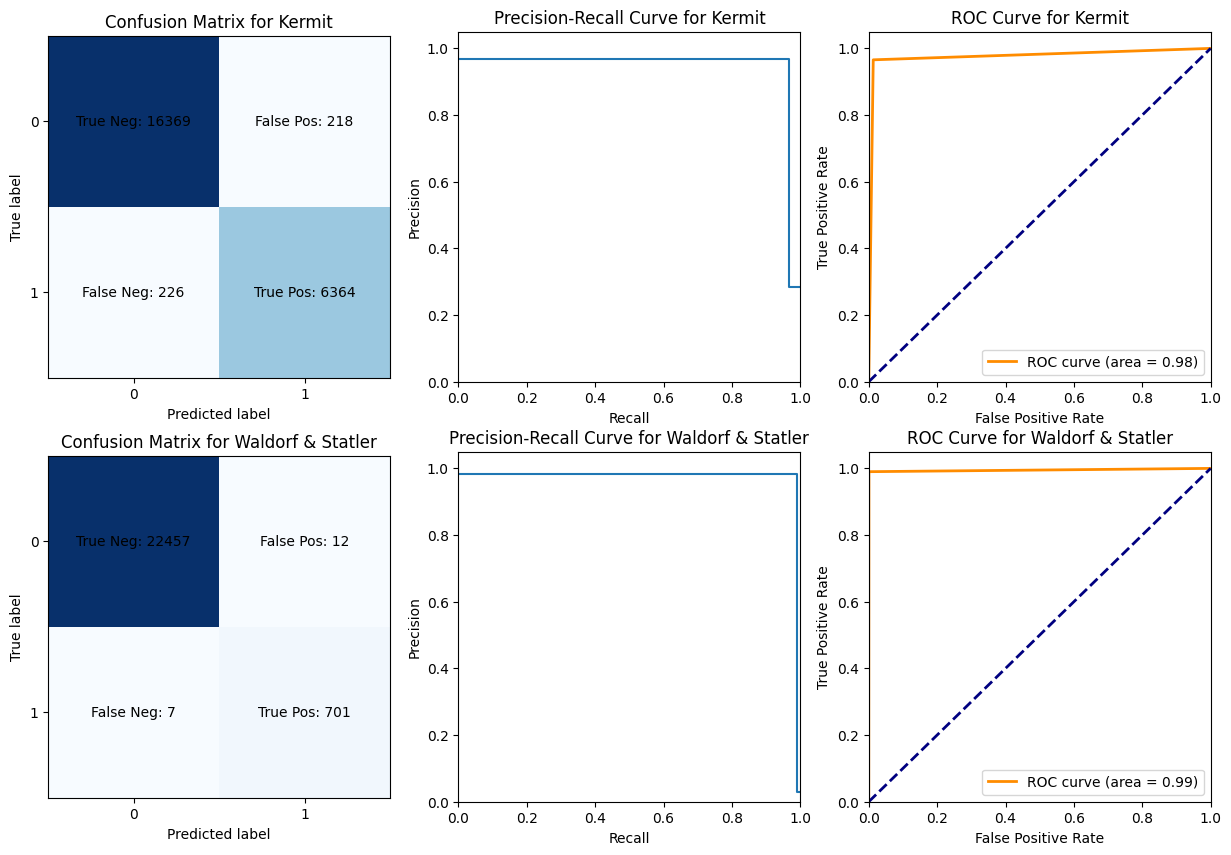

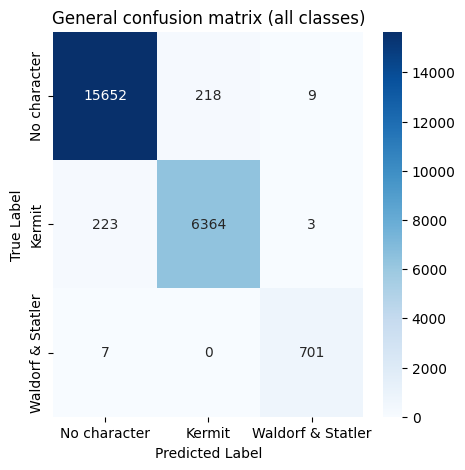

In [26]:
# *** Metrics ***
print(
    f"***General model metrics***\n\tAccuracy: {accuracy_general}\n\tPrecision: {precision_general}\n\tRecall: {recall_general}\n\tF1: {f1_general}"
)
print(
    f"***Kermit***\n\tAccuracy: {accuracy_kermit}\n\tPrecision: {precision_kermit}\n\tRecall: {recall_kermit}\n\tF1: {f1_kermit}\n\tMAP: {map_kermit}"
)
print(
    f"***Waldorf & Statler***\n\tAccuracy: {accuracy_wald_stat}\n\tPrecision: {precision_wald_stat}\n\tRecall: {recall_wald_stat}\n\tF1: {f1_wald_stat}\n\tMAP: {map_wald_stat}"
)

# *** Visual evaluation ***
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# Kermit
plot_confusion_matrix(
    y_test_kermit, y_pred_kermit, "Confusion Matrix for Kermit", ax=axs[0, 0]
)
plot_precision_recall_curve(
    y_test_kermit, y_pred_kermit, "Precision-Recall Curve for Kermit", ax=axs[0, 1]
)
plot_roc_curve(y_test_kermit, y_pred_kermit, "ROC Curve for Kermit", ax=axs[0, 2])
# Waldorf & Statler
plot_confusion_matrix(
    y_test_wald_stat,
    y_pred_wald_stat,
    "Confusion Matrix for Waldorf & Statler",
    ax=axs[1, 0],
)
plot_precision_recall_curve(
    y_test_wald_stat,
    y_pred_wald_stat,
    "Precision-Recall Curve for Waldorf & Statler",
    ax=axs[1, 1],
)
plot_roc_curve(
    y_test_wald_stat, y_pred_wald_stat, "ROC Curve for Waldorf & Statler", ax=axs[1, 2]
)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
plot_global_confusion_matrix(
    y_test,
    y_pred,
    "Kermit",
    "Waldorf & Statler",
)

## Analysis of the results


For the hybrid approach, we combined the audio and visual features for each frame and trained a logistic regression classifier on them. In the audio/visual notebooks, the extracted features were stored in dataframes that were exported as csv files. We loaded these csv files and merged them into one dataframe for the hybrid classifier.  
We then randomly split the data into training and test sets (80/20%) and aggregated the labels for each frame by merging the visual and audio flags (when both are available, which is not the case for Kermit) into a single one (overall presence of the character).  
The final results of the hybrid classifier are shown in the table below. The classifier is of very satisfactory quality overall when using information from both modalities: an area under the roc curve of ~0.99 is obtained for each character. The performance for Waldorf and Statler is particularly good in comparison to the audio-only model that really struggled to detect them. This shows how the visual features are very important for the detection of these characters, even more than for Kermit.

Another thing we noticed in our hybrid experiments was the importance of scaling the features. We tried to train the classifier with and without scaling and the results were very different. Without scaling, the classifier was not able to learn anything and the predictions were always 0.5 (random guessing). This is because the features have very different scales due to their different nature and the classifier is not able to learn anything from them. After scaling, the classifier was able to learn and the results were very good. Hyperparameter tuning of the logistic regression classifier was also very important to obtain good results.  
For example, the same classifier with default hyperparameters and no scaling obtained an area under the roc curve of 0.65 for Kermit and 0.5 for Waldorf and Statler, leading to a completely useless model for Waldorf and Statler. These steps were essential in our process to obtain good results for the hybrid classifier.

**Performance of the hybrid classifier:**

<table>
<thead>
  <tr>
    <th><b>Experiment</b></th>
    <th><b>F1</b></th>
    <th><b>Accuracy</b></th>
    <th><b>Precision</b></th>
    <th><b>Recall</b></th>
  </tr>
</thead>
<tbody>
  <tr>
    <td><b>Kermit detection</b></td>
    <td>0.9663</td>
    <td>0.9808</td>
    <td>0.9669</td>
    <td>0.9657</td>
  </tr>
  <tr>
    <td><b>Waldorf & Statler detection</b></td>
    <td>0.9866</td>
    <td>0.9992</td>
    <td>0.9832</td>
    <td>0.9901</td>

  </tr>
  <tr>
    <td><b>Overall multi-class classification</b></td>
    <td>0.9801</td>
    <td>0.9802</td>
    <td>0.9801</td>
    <td>0.9802</td>
  </tr>
</tbody>
</table>

<img src="../results/sim1_hybrid/results.png" style="max-width:75%; display: block; margin: 0 auto">
